# 8. PyTorch Paper Replicating

The goal fo machine learning reserach paper relicatin gis to turn a ML reserach paper into usable code

In this notebook, we're going to be replicating the Vision Transformer (ViT) architecture / paper with PyTorch

Resource: https://www.learnpytorch.io/08_pytorch_paper_replicating/

## 0. Get setup

Let's import code we've previously written + required libraries

In [59]:
# Import libraries
import torch
import torchvision

from torch import nn
from torchvision import transforms
from torchinfo import summary

import matplotlib.pylab as plt

from src import get_data, setup_data, engine

In [60]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else (
    "mps" if torch.mps.is_available() else "cpu"
)
device

'mps'

## 1. Get data

The whole goal of what we're trying to do is to replicate the ViT architecture for our FoodVision Mini problem

In [61]:
# Download data
get_data.get_data(
    data_dir_str="data",
    image_path_str="pizza_steak_sushi",
    data_url_str="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    file_name_str="pizza_steak_sushi.zip",
)

data/pizza_steak_sushi exists...
Data in data/pizza_steak_sushi already exits, skipping downloading and unzipping...
Finished getting data...


In [62]:
# Setup directories
from pathlib import Path

train_dir = Path("data/pizza_steak_sushi/train")
test_dir = Path("data/pizza_steak_sushi/test")

In [63]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Dataset and DataLoaders

In [64]:
# Create image size
IMG_SIZE = 224 # comes from Table 3 of ViT paper

# Create transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [65]:
# Create a batch size of 32 (paper uses 4096 but this may be too big for our smaller hardware... can always scale up later)
BATCH_SIZE = 32

# Create DataLoaders
train_dataloader, test_dataloader, class_names = setup_data.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE,
    num_workers=1
)

In [66]:
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

In [67]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from batch
image, label = image_batch[0], label_batch[0]

# View batch shapes
image.shape, label

/Users/mchojna/Documents/GitHub/pytorch-course/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


(torch.Size([3, 224, 224]), tensor(0))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

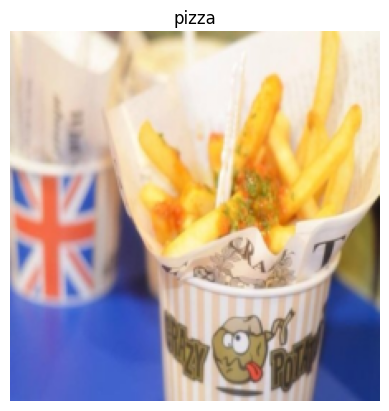

In [68]:
# Plot image with matplotlib

plt.imshow(image.permute(1, 2, 0)) # [color_channels, height, width] -> [height, width, color_channel]
plt.title(class_names[label])
plt.axis(False)

## 3. Replicating ViT

Lookin at the whole machine learning reserach paper can be imtimidating

So in order to make it more understandable, we can break it down into smaller pieces

* **Inputs** - what goes into the model (in our case, image tensors)
* **Outputs** - what comes out of the model (in our case, we want the model to output image classification label)
* **Layers** - takes an input, manipulates it wuth a functino (for example could be self-attention)
* **Blocks** - collection of layers
* **Model (or architecture)** - collection of blocks

### 3.1 ViT overview

* Figure 1: Visual overview of the architecture
* Four equations: math equations which define the functinos of each layer / block
* Table 1/3: different hyperparameteres for the architecture / training

### Figure 1

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-architecture-overview.png" width=600 alt="figure 1 from vision transformer paper"/>

* Embedding = learnable representation (start with random numbers and improve over time) 



### Four equations

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png" width=600 alt="four equations from vision transformer paper"/>

#### Section 3.1 describes the various equations:

**Equation 1:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

**Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable $1 \mathrm{D}$ position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

In pseudocode:

```python
# Equation 1
x_input = [class_token, image_patch_1, image_patch_2, ... image_patch_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos, ... image_patch_N_pos]
```


**Equations 2&3:**
The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

In pseudocode:

```python
# Equation 2 
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# Equation 3 
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block 
```

**Equation 4:**
Similar to BERT's [ class ] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_{L}^{0}\right)$ serves as the image representation y (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_{L}^{0}$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

* MLP = multilayer perceptron = a neural network with X number of layers
* MLP = one hidden layer at training time
* MLP = single linear layer at fine-tuning time 

In pseudocode:

```python
# Equation 4
y = Linear_layer(LN_layer(x_output_MLP_block)) 
```

### Table 1 

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-table-1.png" width=600 alt="table 1 from vision transformer paper"/>

* ViT-Base, ViT-Large and ViT-Huge are all different sizes of the same model architecture
* ViT-B/16 = ViT-Base with image patch size 16x16 
* Layers - the number of transformer encoder layers 
* Hidden size $D$ - the embedding size throughout the architecture
* MLP size - the number of hidden units/neurons in the MLP
* Heads - the number of multi-head self-attention 


## 4. Equation 1: Split data into patches and creating the class, position and patch embedding

Layers = input -> function -> output

What's the input shape?

What's the output shape?

* Input shape: (224, 224, 3) -> single image -> (height, width, color channels)
* Output shape: ???

### 4.1 Calculate input and output shapes by hand

> **Equation 1:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

> **Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable $1 \mathrm{D}$ position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

* Input shape: $H\times{W}\times{C}$ (height x width x color channels)
* Output shape: ${N \times\left(P^{2} \cdot C\right)}$
* H = height
* W = width
* C = color channels
* P = patch size
* N = number of patches = (height * width) / p^2
* D = constant latent vector size = embedding dimension (see Table 1)


In [69]:
# Create evample values
height = 224
width = 224
color_channels = 3
patch_size = 16

In [70]:
# Calulcate number of pathes
number_of_pathes = int((height * width)  / patch_size ** 2)
number_of_pathes

196

In [71]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_input_shape

(224, 224, 3)

In [72]:
# Output shape
embedding_layer_output_shape = (number_of_pathes, patch_size ** 2 * color_channels)
embedding_layer_output_shape

(196, 768)

### 4.2 Turning a single image into patches

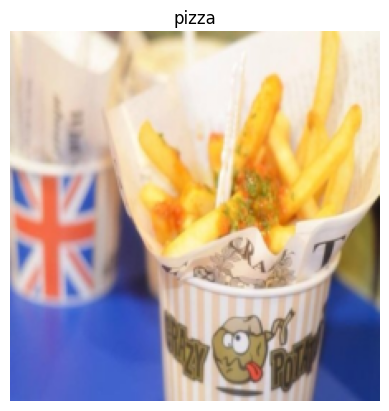

In [73]:
# View a single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
plt.show()

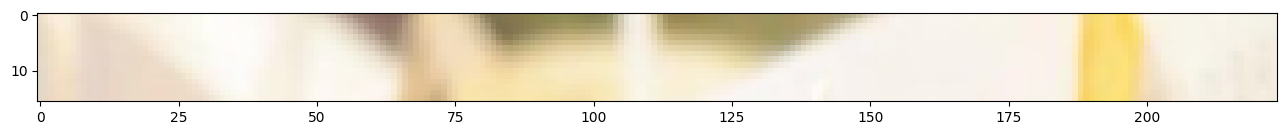

In [74]:
# Get top row of image
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

In [75]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size

assert img_size % patch_size == 0, "Image size must be divisible by patch size"

num_patches, patch_size

(14.0, 16)

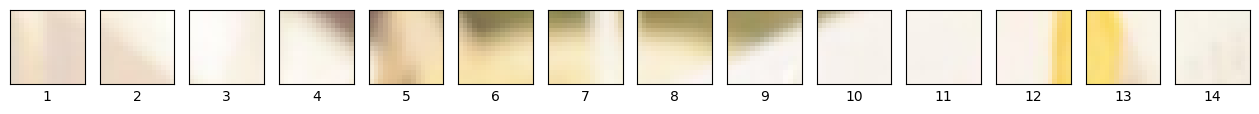

In [76]:
# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size,  # one column for each patch
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size))

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0 ,img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
    axs[i].set_xlabel(i+1) # set the patch label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

In [77]:
# Setup code to plot whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size

assert img_size % patch_size == 0, "Image size must be divisible by patch size"

num_patches, num_patches * num_patches, patch_size

(14.0, 196.0, 16)

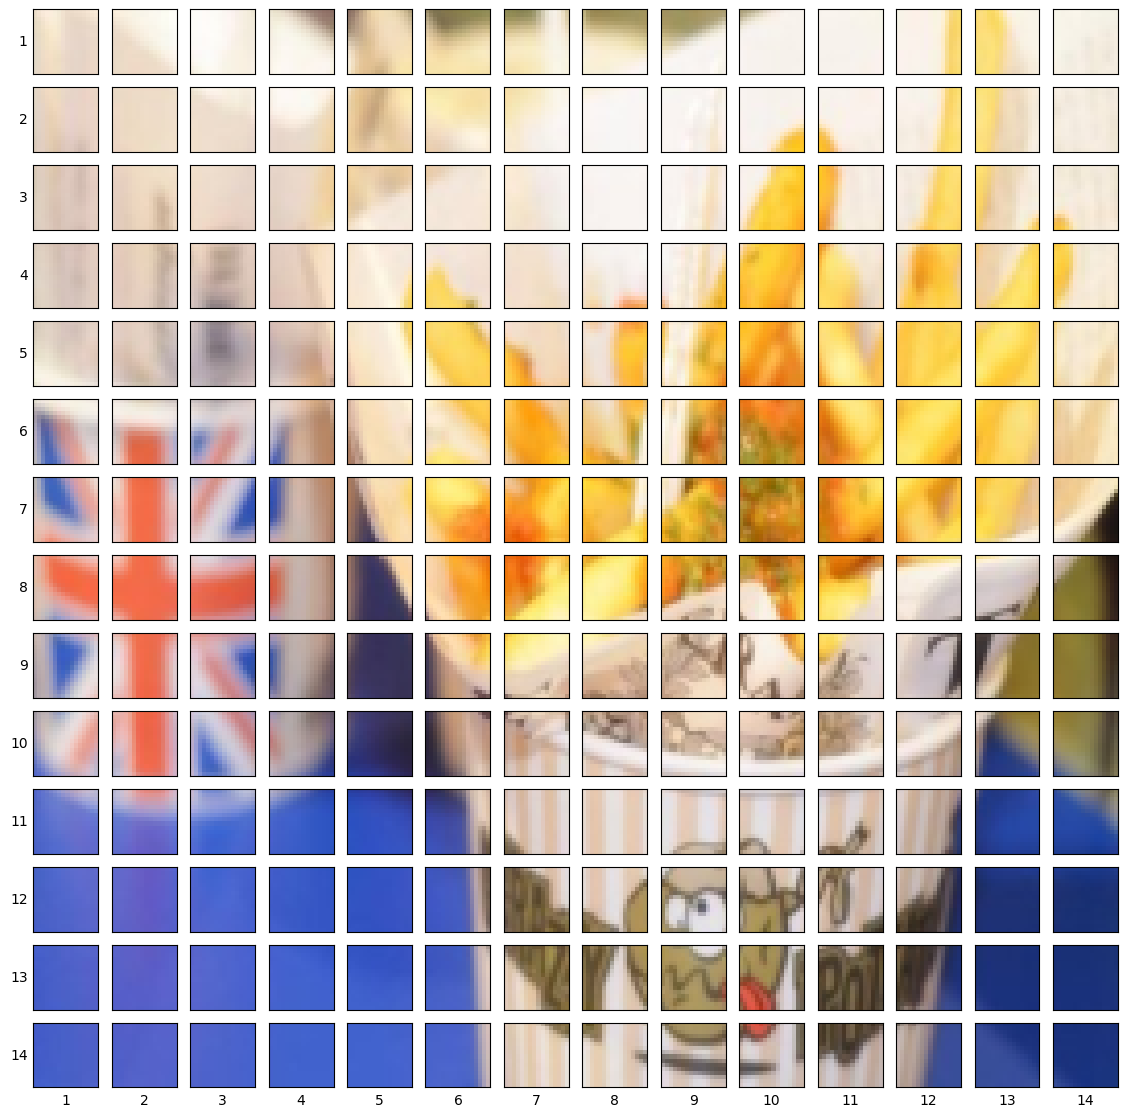

In [78]:
# Create a series of subplot
fix, axs = plt.subplots(nrows=img_size // patch_size,
                         ncols=img_size // patch_size,
                         figsize=(num_patches, num_patches),
                         sharex=True,
                         sharey=True,
)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        # Plot permuted image on different axes
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                        patch_width:patch_width+patch_size,
                                        :])

        axs[i, j].set_ylabel(i+1,
                              rotation="horizontal",
                              horizontalalignment="right",
                              verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()
    
fig.suptitle(f"{class_names[label]}")
plt.show()

### 4.3 Creating image patches and turning them into patch embeddings

We could create the image patches and image patch embedding in a single step using `torch.nn.Conv2D()` and setting the kernel size and stride values to `patch_size`

In [79]:
# Create conv2d layer to trun image into patches of learnable feature map (embeddings)

# set patch size
patch_size = 16

# Create a conv2d layer with hyperparameters from ViT paper
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

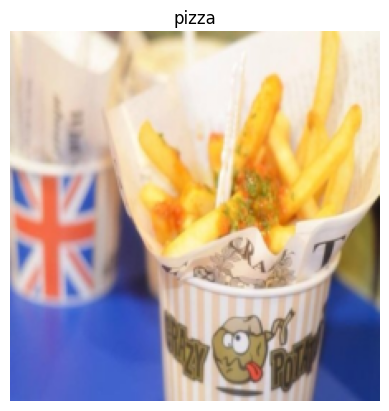

In [80]:
# View single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [81]:
# View single imagePass imaeg through convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension -> (batch_size, color_channels, height, width)
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

In [82]:
14 * 14

196

Now we've passed a single image to our `conv2d` layer, it's hape is: `torch.Size([1, 768, 14, 14])` - `[batch_size, embedding_dim, patch_size, patch_size]`

In [83]:
image_out_of_conv.requires_grad

True

Showing random convolutional feature maps from indexes: [260, 96, 104, 281, 106]


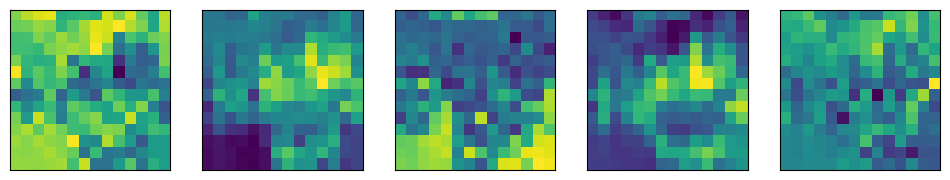

In [84]:
# Plot random convolutional feature maps (embedding)
import random
random_indexes = random.sample(range(0, 758), k=5)

print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1,
                        ncols=5,
                        figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the conv2d layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # remove batch dim, remove from grad tracking, switch to numpy
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [85]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[0.6635, 0.7267, 0.7521, 0.6843, 0.6235, 0.5492, 0.6368, 0.5823,
           0.5957, 0.7418, 0.7372, 0.6895, 0.7016, 0.7273],
          [0.6424, 0.6535, 0.6928, 0.6963, 0.5546, 0.6224, 0.7060, 0.7485,
           0.7535, 0.7629, 0.7293, 0.7034, 0.6792, 0.6972],
          [0.6063, 0.5980, 0.6658, 0.6394, 0.6449, 0.6997, 0.7238, 0.7457,
           0.7367, 0.5407, 0.6806, 0.5998, 0.6568, 0.6946],
          [0.6085, 0.5867, 0.5408, 0.6170, 0.6903, 0.7242, 0.6923, 0.7552,
           0.6494, 0.4372, 0.7147, 0.4572, 0.6186, 0.7163],
          [0.6551, 0.5708, 0.4930, 0.5886, 0.7125, 0.5401, 0.5942, 0.5661,
           0.6125, 0.3578, 0.5600, 0.4911, 0.5517, 0.6902],
          [0.5149, 0.6164, 0.5256, 0.3799, 0.6186, 0.5562, 0.4546, 0.4708,
           0.5419, 0.3468, 0.4447, 0.5475, 0.5263, 0.6090],
          [0.5007, 0.4832, 0.4592, 0.4563, 0.3970, 0.5455, 0.3371, 0.4351,
           0.3056, 0.2963, 0.3846, 0.4034, 0.5256, 0.4265],
          [0.4896, 0.3751, 0.5060, 0.4533, 0.2286, 0.43

### 4.4 Flattening patch embedding with `torch.nn.Flatten()`

Right now we've a seires of convolutional feature map (patch embeddings) that we want to flatten into a sequence of patch embeddings to satisfy criteria of the ViT Transformer Encoder

In [86]:
print(f"{image_out_of_conv.shape} -> (batch_size, embedding_dim, feature_map_hegiht, feature_map_width)")

torch.Size([1, 768, 14, 14]) -> (batch_size, embedding_dim, feature_map_hegiht, feature_map_width)


In [87]:
flatten_layer = nn.Flatten(start_dim=2, 
                           end_dim=3)
flatten_layer

Flatten(start_dim=2, end_dim=3)

In [88]:
flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])


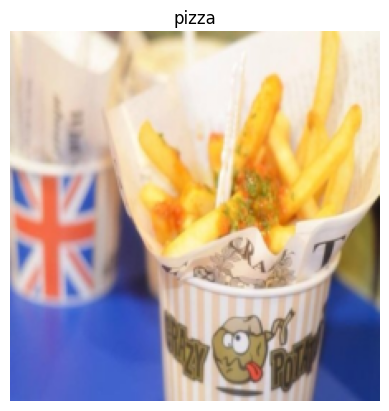

In [89]:
# Put everything together
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

In [90]:
# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(dim=0))
print(f"Image feature map (patches) shape: {image_out_of_conv.shape}")

Image feature map (patches) shape: torch.Size([1, 768, 14, 14])


In [91]:
# Flatten feature map
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

Flattened image feature map shape: torch.Size([1, 768, 196])


In [92]:
# Rearrange output of flattened layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1)

print(f"Permuted image feature map shape: {image_out_of_conv_flattened_permuted.shape} -> (batch_size, number_of_patches, embedding_dimension)")

Permuted image feature map shape: torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embedding_dimension)


In [93]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_permuted[: ,:, 0]
single_flattened_feature_map

tensor([[0.6635, 0.7267, 0.7521, 0.6843, 0.6235, 0.5492, 0.6368, 0.5823, 0.5957,
         0.7418, 0.7372, 0.6895, 0.7016, 0.7273, 0.6424, 0.6535, 0.6928, 0.6963,
         0.5546, 0.6224, 0.7060, 0.7485, 0.7535, 0.7629, 0.7293, 0.7034, 0.6792,
         0.6972, 0.6063, 0.5980, 0.6658, 0.6394, 0.6449, 0.6997, 0.7238, 0.7457,
         0.7367, 0.5407, 0.6806, 0.5998, 0.6568, 0.6946, 0.6085, 0.5867, 0.5408,
         0.6170, 0.6903, 0.7242, 0.6923, 0.7552, 0.6494, 0.4372, 0.7147, 0.4572,
         0.6186, 0.7163, 0.6551, 0.5708, 0.4930, 0.5886, 0.7125, 0.5401, 0.5942,
         0.5661, 0.6125, 0.3578, 0.5600, 0.4911, 0.5517, 0.6902, 0.5149, 0.6164,
         0.5256, 0.3799, 0.6186, 0.5562, 0.4546, 0.4708, 0.5419, 0.3468, 0.4447,
         0.5475, 0.5263, 0.6090, 0.5007, 0.4832, 0.4592, 0.4563, 0.3970, 0.5455,
         0.3371, 0.4351, 0.3056, 0.2963, 0.3846, 0.4034, 0.5256, 0.4265, 0.4896,
         0.3751, 0.5060, 0.4533, 0.2286, 0.4364, 0.4322, 0.5898, 0.4505, 0.4009,
         0.4214, 0.6328, 0.5

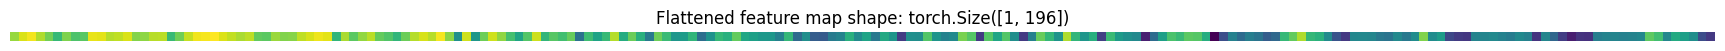

In [94]:
# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)
plt.show()

### 4.5 Turining the ViT patch embedding layer into a PyTorch module

We want this module to do a few things:
1. Create a class called `PatchEmbedding` form `nn.Module`
2. Initalize with appropriate hyperparameters, such as channels, embedding dimension, patch size
3. Create a lyer to turn an image into embedding patches using `nn.Conv2d()`
4. Create a layer to flatten feature maps of the output of the layer in 3.
5. Define a `forward()` that defines forward computation (e.g. pass through layer from 3 and 4)
6. Make sure the output shape of the layer reflects the required output shape of the patch embedding

In [95]:
# 1. Create a class
class PatchEmbedding(nn.Module):
    # 2. Initialize layer with appropriate hyperparameters
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768) -> None:
        super().__init__()
        
        self.patch_size = patch_size
        
        # 3. Create a layer to turn image into embedding
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0,)
        
        # 4. Create a layer to flatten feature map outputs of conv2d
        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3,)
        
    # 5. Define a forward method
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Create assertion to check that inputs are correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"
        
        # Perform forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        
        # 6. Make sure returned sequence embbeding dimension are in the right order (batch_size, number_of patches, embedding_dim)
        x_permuted = x_flattened.permute(0, 2, 1)
        
        return x_permuted

In [96]:
torch.manual_seed(42)

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through embedding layer
print(f"Input image size: {image.unsqueeze(0).shape}")

patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension

print(f"Output patch embedding sequence shape: {patch_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])


In [97]:
rand_image_tensor = torch.randn(1, 3, 224, 224)
rand_image_tensor_bad = torch.randn(1, 3, 250, 250)

patchify(rand_image_tensor)
# patchify(rand_image_tensor_bad)

tensor([[[-0.3601,  0.2602, -0.7408,  ..., -1.2910, -0.2012, -0.0354],
         [-0.3405,  0.6132,  0.6626,  ..., -0.6314, -1.8604,  0.3311],
         [-0.0176, -0.2323, -0.1009,  ...,  0.1873,  0.6899, -0.5419],
         ...,
         [ 0.5333, -0.7641, -0.1217,  ...,  0.2381,  0.5565,  0.0466],
         [-0.6577, -0.0324, -0.6278,  ..., -0.1591,  0.7905,  1.4529],
         [-1.1716, -0.1617, -0.1427,  ...,  0.5600,  0.4640,  0.7539]]],
       grad_fn=<PermuteBackward0>)

### 4.6 Creating class token embedding

Want to: prapend a learnable class token to the start of the patch embedding

In [98]:
patch_embedded_image

tensor([[[-0.9367,  0.2304, -0.2421,  ...,  0.6643, -0.4334,  0.3613],
         [-1.0070,  0.2692, -0.2000,  ...,  0.7158, -0.4675,  0.3300],
         [-1.0018,  0.2214, -0.2645,  ...,  0.7654, -0.4640,  0.3747],
         ...,
         [-0.4357,  0.0886, -0.2266,  ...,  0.2279, -0.1188,  0.4053],
         [-0.2672,  0.0792, -0.1765,  ...,  0.2662, -0.0755,  0.1098],
         [-0.2222,  0.0906, -0.1315,  ...,  0.2308, -0.0616,  0.0505]]],
       grad_fn=<PermuteBackward0>)

In [99]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [100]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

batch_size, embedding_dimension

(1, 768)

In [101]:
# Create class token embedding as a lernable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True,)

class_token.shape

torch.Size([1, 1, 768])

In [102]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [103]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                 dim=1) # number of patches dimension

patch_embedded_image_class_embedding.shape # (batch_size, class_token + number_of_patches, embedding_dim)

torch.Size([1, 197, 768])

In [104]:
patch_embedded_image_class_embedding

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.9367,  0.2304, -0.2421,  ...,  0.6643, -0.4334,  0.3613],
         [-1.0070,  0.2692, -0.2000,  ...,  0.7158, -0.4675,  0.3300],
         ...,
         [-0.4357,  0.0886, -0.2266,  ...,  0.2279, -0.1188,  0.4053],
         [-0.2672,  0.0792, -0.1765,  ...,  0.2662, -0.0755,  0.1098],
         [-0.2222,  0.0906, -0.1315,  ...,  0.2308, -0.0616,  0.0505]]],
       grad_fn=<CatBackward0>)

### 4.7 Creating the position embedding

Want to: create a sequence of 1D lernable embedding and to add them to the sequence of patch embeddings

In [105]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_class_embedding, patch_embedded_image_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.9367,  0.2304, -0.2421,  ...,  0.6643, -0.4334,  0.3613],
          [-1.0070,  0.2692, -0.2000,  ...,  0.7158, -0.4675,  0.3300],
          ...,
          [-0.4357,  0.0886, -0.2266,  ...,  0.2279, -0.1188,  0.4053],
          [-0.2672,  0.0792, -0.1765,  ...,  0.2662, -0.0755,  0.1098],
          [-0.2222,  0.0906, -0.1315,  ...,  0.2308, -0.0616,  0.0505]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [106]:
# Calculate N (number_of_patches)
number_of_pathes = int((height * width) / patch_size ** 2)
number_of_pathes

196

In [107]:
# Get the embedding dimension
embedding_dimension = patch_embedded_image_class_embedding.shape[-1]
embedding_dimension

768

In [108]:
# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1, 
                                             number_of_pathes+1,
                                             embedding_dimension),
                                  requires_grad=True)
position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [109]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_class_embedding + position_embedding
patch_and_position_embedding, patch_and_position_embedding.shape

(tensor([[[ 2.0000,  2.0000,  2.0000,  ...,  2.0000,  2.0000,  2.0000],
          [ 0.0633,  1.2304,  0.7579,  ...,  1.6643,  0.5666,  1.3613],
          [-0.0070,  1.2692,  0.8000,  ...,  1.7158,  0.5325,  1.3300],
          ...,
          [ 0.5643,  1.0886,  0.7734,  ...,  1.2279,  0.8812,  1.4053],
          [ 0.7328,  1.0792,  0.8235,  ...,  1.2662,  0.9245,  1.1098],
          [ 0.7778,  1.0906,  0.8685,  ...,  1.2308,  0.9384,  1.0505]]],
        grad_fn=<AddBackward0>),
 torch.Size([1, 197, 768]))

### 4.8 Putting it all together: from image to embedding

We've written code to turn an image in a flattened sequence of patch embeddings

Now let's it all in one cell

In [110]:
# Set seed
torch.manual_seed(42)

# 1. Set the patch size
patch_size = 16

# 2. Print shapes of the original image tensor and ge the image dimension
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3, 
                                       patch_size=16,
                                       embedding_dim=768,)

# 5. Pass input image through PatchEmbedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]

class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True,)
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) // patch_size ** 2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## 5. Equation 2: Multihead Self-Attention (MSA block)

* **Multihead self-attention** = which part of a sequence should pay the most attention to itself?
  * In our case, we have a series of embedded image patches, which patch significantly relates to another patch.
  * We want our neural network (ViT) to learn this relationship/representation
* To replicate MSA in PyTorch we can use: https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html 

* **LayerNorm** = Layer normalization (LayerNorm) is a technique to normalize the distributions of intermediate layers. It enables smoother gradients, faster training, and better generalization accuracy
  * Normalization = make everything have the same mean and same standard deviation
  * In PyTorch = https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html, normalizes values over $D$ dimension, in our case, the $D$ dimension is the embedding dimension 
    * When we normalize along the embedding dimension, it's like making all of the stairs in a staircase the same size

In [112]:
class MultiHeadAttentionBlock(nn.Module):
    """Creates a multi-head self-attentino block ("MSA block" for short)"""
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 attn_dropout:float=0) -> None:
        super().__init__()
        
        # Create norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # Create multihead attention layer (MSA)
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True,) # is batch first? (batch, seq, feature) -> (batch, number_of_patches, embeeding_dimension)
        
    def forward(self, x):
        x_norm = self.layer_norm(x)
        attn_output, _ =self.multihead_attn(query=x_norm,
                                            key=x,
                                            value=x,
                                            need_weights=False,)
        return attn_output

In [113]:
# Create an instance MSA block
multihead_self_attention_block = MultiHeadAttentionBlock(embedding_dim=768,
                                                         num_heads=12,
                                                         attn_dropout=0)

# Pass the patch and position image embedding sequence through MSA block
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)

In [116]:
patch_and_position_embedding.shape

torch.Size([1, 197, 768])

In [115]:
patched_image_through_msa_block.shape

torch.Size([1, 197, 768])

In [117]:
patch_and_position_embedding

tensor([[[ 2.0000,  2.0000,  2.0000,  ...,  2.0000,  2.0000,  2.0000],
         [ 0.0633,  1.2304,  0.7579,  ...,  1.6643,  0.5666,  1.3613],
         [-0.0070,  1.2692,  0.8000,  ...,  1.7158,  0.5325,  1.3300],
         ...,
         [ 0.5643,  1.0886,  0.7734,  ...,  1.2279,  0.8812,  1.4053],
         [ 0.7328,  1.0792,  0.8235,  ...,  1.2662,  0.9245,  1.1098],
         [ 0.7778,  1.0906,  0.8685,  ...,  1.2308,  0.9384,  1.0505]]],
       grad_fn=<AddBackward0>)

In [118]:
patched_image_through_msa_block

tensor([[[ 0.5789, -0.1657, -0.5158,  ...,  0.1894, -0.3883, -0.2363],
         [ 0.5833, -0.1644, -0.5117,  ...,  0.1869, -0.3873, -0.2379],
         [ 0.5831, -0.1643, -0.5117,  ...,  0.1870, -0.3871, -0.2378],
         ...,
         [ 0.5813, -0.1628, -0.5118,  ...,  0.1874, -0.3852, -0.2382],
         [ 0.5812, -0.1616, -0.5122,  ...,  0.1876, -0.3855, -0.2375],
         [ 0.5809, -0.1620, -0.5129,  ...,  0.1882, -0.3860, -0.2375]]],
       grad_fn=<TransposeBackward0>)